In [1]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np


Using TensorFlow backend.


In [2]:
from zipfile import ZipFile
file_name = "dat2.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

FileNotFoundError: [Errno 2] No such file or directory: 'dat2.zip'

In [3]:
from keras.preprocessing import image
import os
import time

#%% Loading the training data
PATH = os.getcwd()
# Define data path
data_path = PATH + '/data'
data_dir_list = os.listdir(data_path)


img_data_list=[] # created an empty list for images to be loaded

for dataset in data_dir_list:
	img_list=os.listdir(data_path+'/'+ dataset)
	print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
	for img in img_list:
		img_path = data_path + '/'+ dataset + '/'+ img
		img = image.load_img(img_path, target_size=(224, 224))
		x = image.img_to_array(img)
		x = np.expand_dims(x, axis=0)
		#x = preprocess_input(x)
#		x = x/255
		print('Input image shape:', x.shape)
		img_data_list.append(x)

#%% 
img_data = np.array(img_data_list)
#img_data = img_data.astype('float32')
print (img_data.shape)
img_data=np.rollaxis(img_data,1,0)
print (img_data.shape)
img_data=img_data[0]
print (img_data.shape)

Loaded the images of dataset-img_align_celeba

Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape

In [0]:
xtrain = img_data[:5000]
xtest = img_data[5000:]
del img_data_list

In [5]:
img_shape = (224, 224, 3)
batch_size = 16
latent_dim = 32 # Dimensionality of the latent space: a 2D plane
input_img = keras.Input(shape=img_shape)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)

# The input image ends up being encoded into these two parameters
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
# Latent-space-sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])
print(K.int_shape(z))

(None, 32)


In [7]:
decoder_input = layers.Input(K.int_shape(z)[1:]) # Input where you’ll feed z

print(shape_before_flattening)
x = layers.Dense(np.prod(shape_before_flattening[1:]), 
                 activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3,padding='same',
                           activation='relu',strides=(2, 2))(x)
x = layers.Conv2D(3, 3,padding='same',activation='sigmoid')(x)
decoder = Model(decoder_input, x)
z_decoded = decoder(z)

(None, 112, 112, 64)


In [10]:
print(x.shape)

(?, ?, ?, 3)


In [0]:
class CustomVariationalLayer(keras.layers.Layer):
    
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)
    
    #You implement custom layers You don't use by writing a call method.
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x # You don't use this output, but the layer must return something.
    
y = CustomVariationalLayer()([input_img, z_decoded])

In [9]:
from keras.datasets import mnist

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()


vae.fit(x=xtrain, y=None, shuffle=True, epochs=5, 
        batch_size=batch_size, validation_data=(xtest, None))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 112, 112, 64) 18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 112, 112, 64) 36928       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

KeyboardInterrupt: ignored

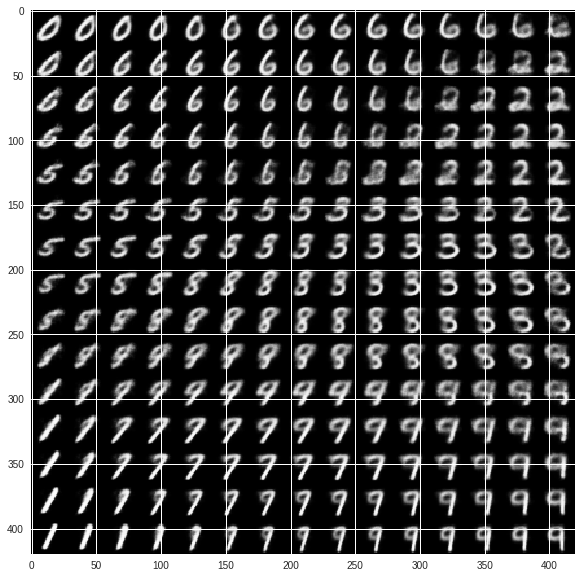

In [16]:
import matplotlib.pyplot as plt
from scipy.stats import norm
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit
        
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()